<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta 
import os
import re

from functools import reduce
from collections import defaultdict

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'scanner_data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'match_result_test.csv',
 '1_orders_dataset.csv',
 'sales.csv',
 'ecommerce-data.csv',
 'sample-sales-data.csv',
 'online_retail.xlsx',
 '1_customers_dataset.csv',
 'sales_data_with_stores.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'groceries.csv',
 'mall_customers.csv',
 '1_order_payments_dataset.csv',
 'bz_data_analyis.csv',
 'online_retail_II.xlsx',
 'sales_vs_discount.csv',
 'mock_sales_data.csv',
 'test.csv',
 'sample_data']

In [10]:
df_order = pd.read_csv('1_orders_dataset.csv')
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])
df_order['date'] = df_order['order_purchase_timestamp'].to_numpy().astype('datetime64[D]')
df_order['week'] = df_order['date'] - df_order['date'].dt.weekday.astype('timedelta64[D]')
df_pay = pd.read_csv('1_order_payments_dataset.csv')
df_order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date,week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 0:00:00,2017-10-02,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 3:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 0:00:00,2018-07-24,2018-07-23
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 8:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 0:00:00,2018-08-08,2018-08-06
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 0:28:42,2017-12-15 0:00:00,2017-11-18,2017-11-13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 0:00:00,2018-02-13,2018-02-12


In [17]:
df_pay = df_pay[['order_id', 'payment_value']]
df_pay.head()

,order_id,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,65.71
3,ba78997921bbcdc1373bb41e913ab953,107.78
4,42fdf880ba16b47b59251dd489d4441a,128.45


In [20]:
df_order = df_order[['order_id', 'customer_id', 'week', 'date']]
df_order.head()

,order_id,customer_id,week,date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-23,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-06,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-13,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-12,2018-02-13


In [21]:
df = pd.merge(df_order, df_pay, 'left', 'order_id')
df.head()

,order_id,customer_id,week,date,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,2017-10-02,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,2017-10-02,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,2017-10-02,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-23,2018-07-24,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-06,2018-08-08,179.12


In [25]:
list_id = dict(zip(df['customer_id'].unique().tolist(), range(len(df['customer_id'].unique()))))

In [27]:
df['customer_id'] = df['customer_id'].apply(lambda x : list_id.get(x, x))
df.head()

,order_id,customer_id,week,date,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,0,2017-10-02,2017-10-02,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,0,2017-10-02,2017-10-02,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,0,2017-10-02,2017-10-02,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,1,2018-07-23,2018-07-24,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,2,2018-08-06,2018-08-08,179.12


In [28]:
cnt = df.groupby(['customer_id', 'week'])['payment_value'].agg(['sum', 'count']).reset_index()
cnt.columns = ['id','week','rev','freq']
cnt.head()

,id,week,rev,freq
0,0,2017-10-02,38.71,3
1,1,2018-07-23,141.46,1
2,2,2018-08-06,179.12,1
3,3,2017-11-13,72.20,1
4,4,2018-02-12,28.62,1


In [47]:
def get_ret(df) :

  list_week = df['week'].sort_values().unique()
  list_npu = df.sort_values(['id','week'], ascending=[1,1]).groupby(['id']).head(1)

  res = list()

  for weeks in list_week :
    
    temp_npu = list_npu[list_npu['week'] == weeks]
    temp_pu = df[df['id'].isin(temp_npu['id'])]

    temp = temp_pu.groupby(['week'])['id'].count().reset_index()
    temp.rename(columns = {'id':'pu'}, inplace = True)
    temp = temp.assign(
        
        nums = (temp['week'] - weeks) ,
        week = str(weeks)[:10] ,
        ratio = temp['pu'].apply(lambda x : round(x/temp['pu'].max()*100,2))

    )

    temp = temp[['week', 'nums', 'pu', 'ratio']]
    res.append(temp)
  
  res = pd.concat(res).reset_index().drop(['index'], axis = 1)

  return res

In [48]:
res = get_ret(cnt)
res.head()

,week,nums,pu,ratio
0,2016-08-29,0 days,1,100.0
1,2016-09-05,0 days,1,100.0
2,2016-09-12,0 days,2,100.0
3,2016-09-26,0 days,1,100.0
4,2016-10-03,0 days,283,100.0


In [54]:
res['nums'].value_counts()

0 days    101
Name: nums, dtype: int64

/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


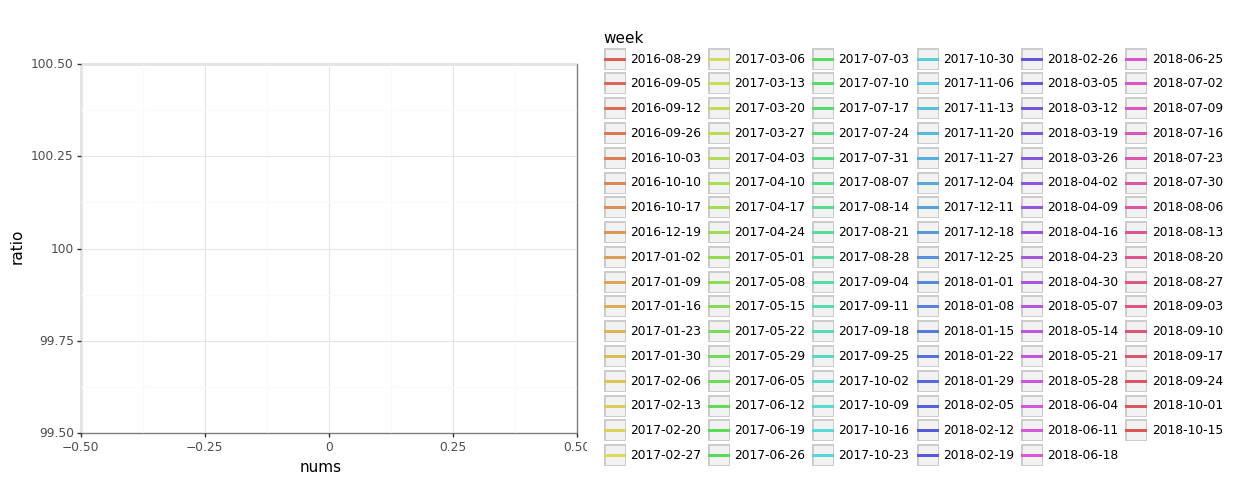

<ggplot: (8789668625701)>

In [43]:
(
    ggplot(res, aes('nums', 'ratio', color = 'week')) + 
    gg.geom_line() +
    gg.theme_bw()
)

In [53]:
df['customer_id'].value_counts().reset_index()

,index,customer_id
0,25932,29
1,77686,26
2,7694,22
3,71529,21
4,86132,19
...,...,...
99436,33647,1
99437,33646,1
99438,33645,1
99439,33644,1


# Iterators

In [55]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [56]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}